---
title: Exploring language metadata for datasets on the Hugging Face Hub
description: Using the huggingface_hub library to asses metadata on the hub
author: "Daniel van Strien"
date: "2023-06-07"
---

In [3]:
%pip install huggingface_hub backoff wordcloud tabulate toolz matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
from huggingface_hub import list_datasets
from toolz import valmap, countby, groupby, topk, valmap
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Load datasets

In [5]:
datasets = list(iter(list_datasets(full=True, sort="downloads", direction=-1)))

In [6]:
def get_lang(dataset):
    card_data = dataset.cardData
    if card_data:
        lang = card_data.get("language")
        if lang is None:
            return False
        if len(lang) >= 1:
            return True
    if not card_data:
        return "No card data"

In [7]:
has_lang = groupby(get_lang, datasets)

In [8]:
has_lang.keys()

dict_keys([True, 'No card data', False, None])

In [9]:
has_language_freqs = countby(get_lang, datasets)
has_language_percents = valmap(
    lambda x: round(x / sum(has_language_freqs.values()) * 100, ndigits=2),
    has_language_freqs,
)

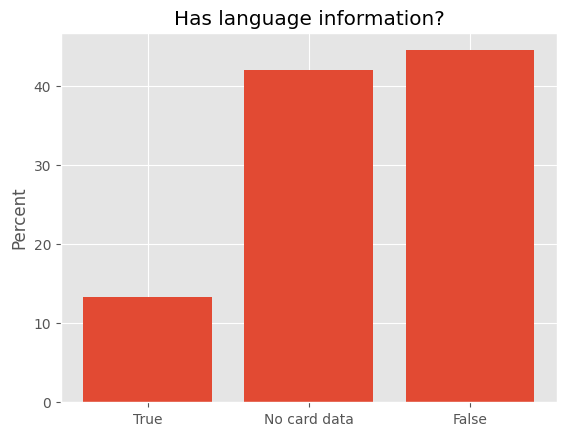

In [10]:

plt.style.use("ggplot")
data = {True: 13.31, "No card data": 42.03, False: 44.5}
# Convert the keys to strings
keys = [str(key) for key in data]

# Separate the values from the dictionary
values = list(data.values())

# Create a bar chart
plt.bar(keys, values)

# Set the labels for x and y axes
plt.ylabel("Percent")

# Set the title of the chart
plt.title("Has language information?")

# Display the chart
plt.show()

## Filter to datasets with language information

In [11]:
with_lang = has_lang[True]

In [12]:
def count_langs(dataset):
    langs = dataset.cardData.get("language")
    return len(langs)

# Top ten most frequent languages amounts

In [ ]:
countby(count_langs, with_lang).items(), key=lambda x: x[1]

In [13]:
topk(10, countby(count_langs, with_lang).items(), key=lambda x: x[1])

((1, 5107),
 (2, 662),
 (3, 76),
 (4, 35),
 (6, 28),
 (11, 26),
 (7, 23),
 (5, 20),
 (12, 19),
 (10, 18))

highest number of languages

In [14]:
max(countby(count_langs, with_lang).keys())

641

## Get languages

In [15]:
def get_langs(dataset):
    return dataset.cardData.get("language")

In [16]:
from toolz import concat, frequencies

In [17]:
lang_freqs = frequencies(concat(get_langs(d) for d in with_lang))

Number of unique languages specified on the hub

In [18]:
len(lang_freqs.keys())

1719

In [19]:
import pandas as pd

ModuleNotFoundError: No module named 'pandas'

In [ ]:
df = pd.DataFrame({"Language": lang_freqs.keys(), "Frequency": lang_freqs.values()})
df

,Language,Frequency
0,en,3949
1,ja,221
2,ace,19
3,acm,6
4,acq,5
...,...,...
1714,mr-,1
1715,xx,1
1716,nbl,2
1717,sep,1


<Axes: xlabel='Language'>

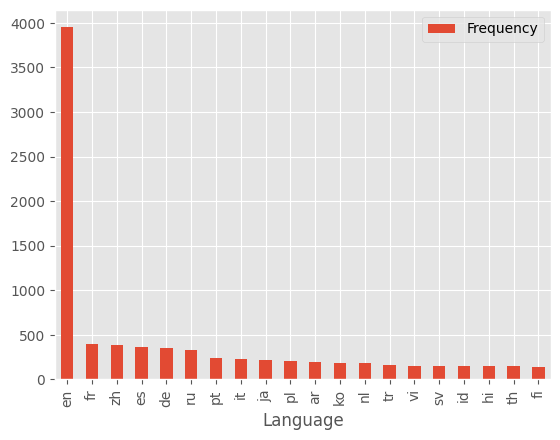

In [ ]:
df.sort_values("Frequency", ascending=False).iloc[:20].set_index("Language").plot.bar()

In [ ]:
df["Percent"] = (df.Frequency / df.Frequency.sum() * 100).round(3)

In [ ]:
print(
    df.sort_values("Frequency", ascending=False)
    .iloc[:20]
    .set_index("Language")
    .to_markdown()
)

| Language   |   Frequency |   Percent |
|:-----------|------------:|----------:|
| en         |        3949 |    19.04  |
| fr         |         394 |     1.9   |
| zh         |         390 |     1.88  |
| es         |         358 |     1.726 |
| de         |         350 |     1.687 |
| ru         |         333 |     1.606 |
| pt         |         238 |     1.147 |
| it         |         229 |     1.104 |
| ja         |         221 |     1.066 |
| pl         |         207 |     0.998 |
| ar         |         195 |     0.94  |
| ko         |         184 |     0.887 |
| nl         |         182 |     0.877 |
| tr         |         156 |     0.752 |
| vi         |         155 |     0.747 |
| sv         |         153 |     0.738 |
| id         |         149 |     0.718 |
| hi         |         148 |     0.714 |
| th         |         145 |     0.699 |
| fi         |         144 |     0.694 |


In [ ]:
df = df.drop(columns="Percent")

<Axes: ylabel='Language'>

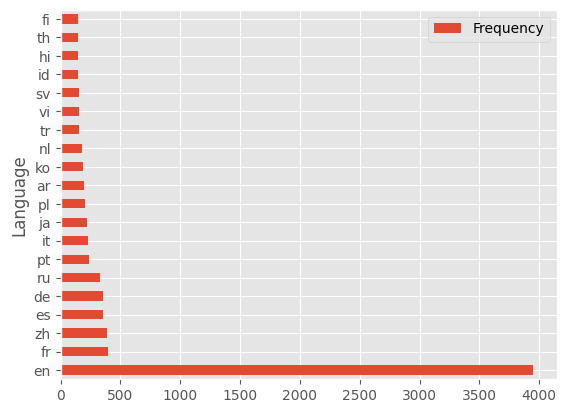

In [ ]:
df.sort_values("Frequency", ascending=False).iloc[:20].set_index("Language").plot.barh()

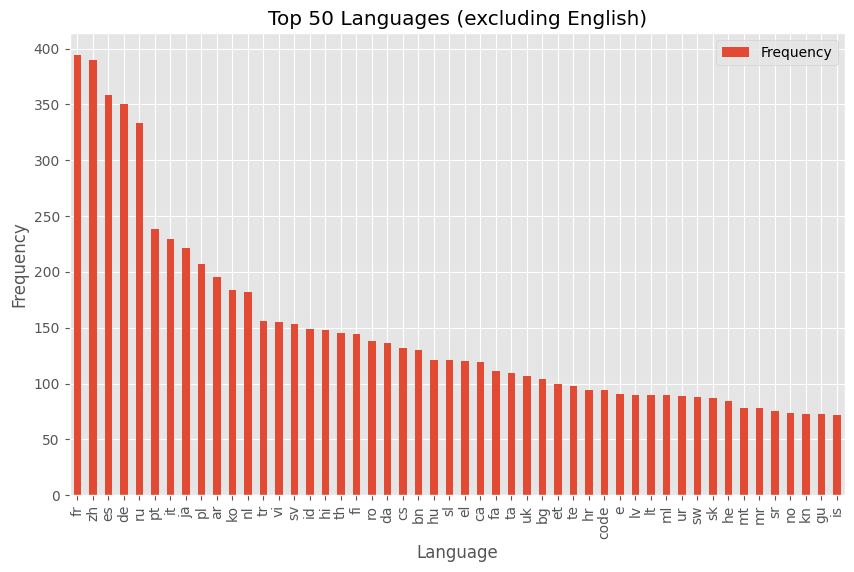

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

df[df.Language != "en"].sort_values("Frequency", ascending=False).iloc[:50].set_index(
    "Language"
).plot.bar(ax=ax)

ax.set_xlabel("Language")
ax.set_ylabel("Frequency")
ax.set_title("Top 50 Languages (excluding English)")
plt.show()

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Define Hugging Face brand colors
hugging_face_colors = ["#FFD21E", "#FF9D00", "#6B7280"]
# Create custom colormap
color_map = LinearSegmentedColormap.from_list("hugging_face", hugging_face_colors)

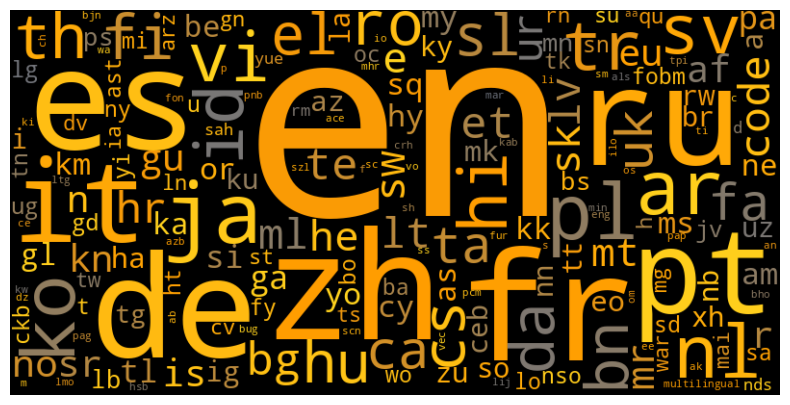

In [ ]:
wordcloud = WordCloud(width=800, height=400, colormap=color_map)

wordcloud.generate_from_frequencies(lang_freqs)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()